In [1]:
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from jupyterthemes import jtplot
from matplotlib.lines import Line2D
import scipy 
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
# np.random.seed(42)
jtplot.reset()
jtplot.reset()

const = 12
SMALL_SIZE = 8 + const  
MEDIUM_SIZE = 10 + const
BIGGER_SIZE = 12 + const

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=20)
np.core.arrayprint._line_width = 1000

# Load Year 2 Data

In [69]:
# define all variables of interest
cbcl_cols = ['cbcl_scr_syn_anxdep_r', 'cbcl_scr_syn_withdep_r', 'cbcl_scr_syn_somatic_r', 'cbcl_scr_syn_social_r',
             'cbcl_scr_syn_thought_r', 'cbcl_scr_syn_attention_r', 'cbcl_scr_syn_rulebreak_r', 'cbcl_scr_syn_aggressive_r']
nih_cols = ['nihtbx_picvocab_uncorrected', 'nihtbx_flanker_uncorrected', #'nihtbx_list_uncorrected',
            #'nihtbx_cardsort_uncorrected', 
            'nihtbx_pattern_uncorrected', 'nihtbx_picture_uncorrected',
            'nihtbx_reading_uncorrected']
sleep_cols = ['sds_p_ss_dims', 'sds_p_ss_sbd','sds_p_ss_da','sds_p_ss_swtd','sds_p_ss_does','sds_p_ss_shy']
pea_cols = ["pea_ravlt_sd_trial_iv_tc","pea_ravlt_ld_trial_vii_tc"] #,"pea_wiscv_trs"]
lmt_cols = ['lmt_scr_num_correct']
upps_cols = ['upps_y_ss_negative_urgency', 'upps_y_ss_lack_of_planning', 'upps_y_ss_sensation_seeking',
             'upps_y_ss_positive_urgency', 'upps_y_ss_lack_of_perseverance', 'pps_y_ss_severity_score']
upps_item_cols = ['upps6_y', 'upps7_y', 'upps11_y', 'upps12_y', 'upps15_y', 'upps16_y', 'upps17_y', 'upps18_y',
                  'upps19_y', 'upps20_y', 'upps21_y', 'upps22_y', 'upps23_y', 'upps24_y', 'upps27_y', 'upps28_y',
                  'upps35_y', 'upps36_y', 'upps37_y', 'upps39_y']
bis_cols = ['bis_y_ss_bis_sum', 'bis_y_ss_bas_rr', 'bis_y_ss_bas_drive', 'bis_y_ss_bas_fs']
sscey_cols = ['srpf_y_ss_ses', 'srpf_y_ss_iiss', 'srpf_y_ss_dfs', 'psb_y_ss_mean', 'fes_y_ss_fc_pr']
sscep_cols = ['psb_p_ss_mean', 'fes_p_ss_fc_pr']
ses_cols = [#'reshist_addr1_adi_wsum', 
            'EdYearsAverage']
pdem_cols = ['household_income']
pf10_cols = ['PF10_lavaan', 'PF10_INT_lavaan', 'PF10_EXT_lavaan']
ses2_cols = ['ses_fac']
g_cols = ['G_lavaan']
bmi_cols = ['bmi']
screen_cols = ['stq_y_ss_weekday', 'stq_y_ss_weekend']
family_cols = ['FHtotal']
med_cols = ['medhx_ss_4b_p_l']
med_cols_2 = ['medhx_2a_l', 'medhx_2d_l']
neigh_crimes_par_cols = ['neighborhood1r_p', 'neighborhood2r_p', 'neighborhood3r_p']
community_cohesion_cols = ['comc_phenx_close_knit_p', 'comc_phenx_help_p', 'comc_phenx_get_along_p', 'comc_phenx_share_values_p',
                           'comc_phenx_trusted_p', 'comc_phenx_skip_p', 'comc_phenx_graffiti_p', 'comc_phenx_disrespect_p',
                           'comc_phenx_fight_p', 'comc_phenx_budget_p']
fitbit_sleep_cols = [
'fit_ss_sleepperiod_minutes',	# total time in sleep
'fit_ss_wake_minutes',  # time awake during sleep
'fit_ss_light_minutes',  # minutes of light sleep
'fit_ss_deep_minutes',  # minutes of deep sleep
'fit_ss_rem_minutes',  # minutes of rem sleep,    
'fit_ss_avg_hr_wake',
]

sleep_fa_cols = ['sleep_fa_scores']

bpmt_questions = ['bpmt_q'+str(x) for x in range(1, 19)]

# get all cbcl item columns
cbcl_item_cols = []
for i in range(1,113):
    if i < 10:
        cbcl_item_cols.append(f'cbcl_q0{i}_p')
    elif i == 56:
        for letter in ['a', 'b', 'c', 'd', 'e', 'f', 'h']:
            cbcl_item_cols.append(f'cbcl_q{i}{letter}_p')
    else:
        cbcl_item_cols.append(f'cbcl_q{i}_p')

all_cols = (cbcl_cols 
            + nih_cols 
            + pea_cols 
            + lmt_cols 
            + upps_cols
            + bis_cols 
            + sscey_cols 
            + sscep_cols 
            + ses_cols 
            + pdem_cols 
            + sleep_cols 
            + bmi_cols 
            + screen_cols
            + med_cols
            + med_cols_2
            + community_cohesion_cols
            + neigh_crimes_par_cols
           )

# now get latent only and subscale columns subsets
nuisance_cols = ['Age', 'Sex', 'RaceEthnicity', 'HouseholdMaritalStatus']
latent_cols = ['G_lavaan', 'PF10_lavaan', 'PF10_INT_lavaan', 'PF10_EXT_lavaan', 'ses_fac']
merge_cols = ['subjectkey', 'eventname']

# paths to read in raw data
path = "" # path to ABCD-NDAR-Release4.0 ABCDStudyNDA data"




In [70]:
y_cols = sleep_cols
x_cols_to_exclude = sleep_fa_cols + sleep_cols

In [72]:
from utils.misc_utils import loso_test_idxs

def filter_year2_data_only(df, cols, followup_event='1_year_follow_up_y_arm_1'):
    assert followup_event in df.eventname.unique()
    return df[df.eventname == followup_event]


with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # load family, site
    fam_df = pd.read_csv(path + "acspsw03.txt", delim_whitespace=True).drop(0)[merge_cols + ['rel_family_id']]
    site_df = pd.read_csv(path + "abcd_lt01.txt", delim_whitespace=True).drop(0)[merge_cols + ['site_id_l']]
    
    # todo: this file was generated by our team
    nuisance_df = pd.read_csv("./ABCD_demographics.csv")
    nuisance_df['parent_marital_status'] = nuisance_df['parent_marital_status'].astype(str).str.replace('1.0', 'married')
    nuisance_df['parent_marital_status'] = nuisance_df['parent_marital_status'].astype(str).str.replace('2.0', 'not_married')
    nuisance_df['parent_marital_status'] = nuisance_df['parent_marital_status'].astype(str).str.replace('3.0', 'not_married')
    nuisance_df['parent_marital_status'] = nuisance_df['parent_marital_status'].astype(str).str.replace('4.0', 'not_married')
    nuisance_df['parent_marital_status'] = nuisance_df['parent_marital_status'].astype(str).str.replace('5.0', 'not_married')
    nuisance_df['parent_marital_status'] = nuisance_df['parent_marital_status'].astype(str).str.replace('6.0', 'not_married')
    nuisance_df['parent_marital_status'] = nuisance_df['parent_marital_status'].astype(str).replace({'777': np.nan, '999': np.nan, 'nan': np.nan})
    nuisance_df['Age'] = nuisance_df['child_age']
    nuisance_df['Sex'] = nuisance_df['child_sex']
    nuisance_df['HouseholdMaritalStatus'] = nuisance_df['parent_marital_status']
    #  1 = White; 2 = Black; 3 = Hispanic; 4 = Asian; 5 = Other
    nuisance_df['RaceEthnicity'] = nuisance_df['child_race_ethnicity']
    nuisance_df['RaceEthnicity'] = nuisance_df['RaceEthnicity'].astype(str).str.replace('1.0', 'White')
    nuisance_df['RaceEthnicity'] = nuisance_df['RaceEthnicity'].astype(str).str.replace('2.0', 'Black')
    nuisance_df['RaceEthnicity'] = nuisance_df['RaceEthnicity'].astype(str).str.replace('3.0', 'Hispanic')
    nuisance_df['RaceEthnicity'] = nuisance_df['RaceEthnicity'].astype(str).str.replace('4.0', 'Asian')
    nuisance_df['RaceEthnicity'] = nuisance_df['RaceEthnicity'].astype(str).str.replace('5.0', 'Other')
    nuisance_df['RaceEthnicity'] = nuisance_df['RaceEthnicity'].astype(str).replace('nan', np.nan)
    nuisance_df['site_id_l'] = nuisance_df['site_id']
    nuisance_df = filter_year2_data_only(nuisance_df, nuisance_cols, '2_year_follow_up_y_arm_1')
    
    # load phenos
    cbcl_df = pd.read_csv("./abcd_cbcls01_nosleep_scales.csv")
    cbcl_df = filter_year2_data_only(cbcl_df, cbcl_cols, '2_year_follow_up_y_arm_1')
    cbcl_df = cbcl_df[merge_cols + cbcl_cols]

    cbcl_item_df = pd.read_csv(path + "abcd_cbcl01.txt", delim_whitespace=True).drop(0)
    cbcl_item_df = filter_year2_data_only(cbcl_item_df, cbcl_item_cols, '2_year_follow_up_y_arm_1')
    cbcl_item_df = cbcl_item_df[merge_cols + cbcl_item_cols]

    bis_upps_df = pd.read_csv(path + "abcd_mhy02.txt", delim_whitespace=True).drop(0)
    bis_upps_df = filter_year2_data_only(bis_upps_df, bis_cols + upps_cols, '2_year_follow_up_y_arm_1')
    bis_upps_df = bis_upps_df[merge_cols + bis_cols + upps_cols]

    upps_item_df = pd.read_csv(path + "abcd_upps01.txt", delim_whitespace=True).drop(0, axis=0)
    upps_item_df = filter_year2_data_only(upps_item_df, upps_item_cols, '2_year_follow_up_y_arm_1')
    upps_item_df[merge_cols + upps_item_cols]

    nih_df = pd.read_csv(path + "abcd_tbss01.txt", delim_whitespace=True).drop(0)
    nih_df = filter_year2_data_only(nih_df, nih_cols, '2_year_follow_up_y_arm_1')
    nih_df = nih_df[merge_cols + nih_cols]

    sscey_df = pd.read_csv(path +"abcd_sscey01.txt", delim_whitespace=True).drop(0)
    sscey_df = filter_year2_data_only(sscey_df, sscey_cols, '2_year_follow_up_y_arm_1')
    sscey_df = sscey_df[merge_cols + sscey_cols]
    
    sscep_df = pd.read_csv(path +"abcd_sscep01.txt", delim_whitespace=True).drop(0)
    sscep_df = filter_year2_data_only(sscep_df, sscep_cols, '2_year_follow_up_y_arm_1')
    sscep_df = sscep_df[merge_cols + sscep_cols]

    pdem_df = nuisance_df.copy()
    pdem_df = filter_year2_data_only(pdem_df, pdem_cols, '2_year_follow_up_y_arm_1')
    pdem_df = pdem_df[merge_cols + pdem_cols]

    pea_df = pd.read_csv(path + "abcd_ps01.txt", delim_whitespace=True).drop(0)
    pea_df = filter_year2_data_only(pea_df, pea_cols, '2_year_follow_up_y_arm_1')
    pea_df = pea_df[merge_cols + pea_cols]

    lmt_df = pd.read_csv(path + "lmtp201.txt", delim_whitespace=True).drop(0)
    lmt_df = filter_year2_data_only(lmt_df, lmt_cols, '2_year_follow_up_y_arm_1')
    lmt_df = lmt_df[merge_cols + lmt_cols]

    sleep_df = pd.read_csv("/nfs/corenfs/psych-freewill-data/Data/ABCD/NDAR/Release4.0/ABCDStudyNDA/abcd_ssphp01.txt", delim_whitespace=True).drop(0)
    sleep_df = filter_year2_data_only(sleep_df, sleep_cols, '2_year_follow_up_y_arm_1')
    sleep_df = sleep_df[merge_cols + sleep_cols]

    ses_df2 = pd.read_csv(path + "abcd_rhds01.txt", delim_whitespace=True).drop(0)
    ses_df2 = filter_year2_data_only(ses_df2, ['reshist_addr1_adi_wsum'], '2_year_follow_up_y_arm_1')
    ses_df2 = ses_df2[merge_cols + ['reshist_addr1_adi_wsum']]
    ses_df2 = ses_df2.merge(nuisance_df[['subjectkey', 'eventname', 'parent_education']], on=merge_cols, how='left')
    ses_df2['EdYearsAverage'] = ses_df2['parent_education']

    bmi_df = pd.read_csv(path + "abcd_ant01.txt", delim_whitespace=True).drop(0)
    bmi_df['height_in'] = np.nanmean(bmi_df[['anthro_1_height_in', 'anthro2heightin', 'anthro3heightin']].astype(float), axis=1)
    bmi_df['weight_lb'] = np.nanmean(bmi_df[['anthroweight1lb', 'anthroweight2lb', 'anthroweight3lb']].astype(float), axis=1)
    bmi_df['bmi'] = 703*(bmi_df['weight_lb'] / bmi_df['height_in']**2)
    bmi_df = bmi_df[(bmi_df['bmi'] < 60) & (bmi_df['bmi'] > 13.5)]
    bmi_df = filter_year2_data_only(bmi_df, bmi_cols, '2_year_follow_up_y_arm_1')
    bmi_df = bmi_df[merge_cols + bmi_cols]

    screen_df = pd.read_csv(path + "abcd_stq01.txt", delim_whitespace=True).drop(0)
    screen_df = filter_year2_data_only(screen_df, screen_cols, '2_year_follow_up_y_arm_1')
    # ['stq_y_ss_weekday', 'stq_y_ss_weekend']
    screen_df['stq_y_ss_weekday'] = screen_df[[x for x in screen_df.columns if ('wkdy_hr' in x) and ('screentime' in x)]].fillna(0).astype(np.float32).values.sum(1)
    screen_df['stq_y_ss_weekend'] = screen_df[[x for x in screen_df.columns if ('wknd_hr' in x) and ('screentime' in x)]].fillna(0).astype(np.float32).values.sum(1)
    screen_df = screen_df[merge_cols + screen_cols]
    
    med_df = pd.read_csv(path + "abcd_lssmh01.txt", delim_whitespace=True).drop(0)
    med_df = filter_year2_data_only(med_df, med_cols, '2_year_follow_up_y_arm_1')
    med_df = med_df[merge_cols + med_cols]
    
    med_df2 = pd.read_csv(path + "abcd_lpmh01.txt", delim_whitespace=True).drop(0)
    med_df_vals_1 = med_df2.medhx_2a_l.values.flatten()
    med_df_vals_2 = med_df2.medhx_2d_l.values.flatten()
    med_df_doc_visits = med_df2.medhx_1a_l.values.flatten()
    no_doc_visit_idxs_1 = np.argwhere((med_df_doc_visits == 0) & np.isnan(med_df_vals_1.astype(np.float32))).flatten()
    no_doc_visit_idxs_2 = np.argwhere((med_df_doc_visits == 0) & np.isnan(med_df_vals_2.astype(np.float32))).flatten()
    med_df_vals_1[no_doc_visit_idxs_1] = 0
    med_df_vals_2[no_doc_visit_idxs_2] = 0
    med_df2['medhx_2a_l'] = med_df_vals_1
    med_df2['medhx_2d_l'] = med_df_vals_2
    med_df2 = filter_year2_data_only(med_df2, med_cols_2, '2_year_follow_up_y_arm_1')
    med_df2 = med_df2[merge_cols + med_cols_2]

    
    comm_df = pd.read_csv(path + "abcd_pxccp01.txt", delim_whitespace=True).drop(0)
    comm_df = filter_year2_data_only(comm_df, community_cohesion_cols, '2_year_follow_up_y_arm_1')
    comm_df[community_cohesion_cols] = comm_df[community_cohesion_cols].astype(float).replace({777: np.nan, 999: np.nan})
    comm_df = comm_df[merge_cols + community_cohesion_cols]

    neigh_parent_df = pd.read_csv(path + "abcd_pnsc01.txt", delim_whitespace=True).drop(0)
    neigh_parent_df = filter_year2_data_only(neigh_parent_df, neigh_crimes_par_cols, '2_year_follow_up_y_arm_1')
    neigh_parent_df = neigh_parent_df[merge_cols + neigh_crimes_par_cols]

    munich_df = pd.read_csv("/nfs/corenfs/psych-freewill-data/Data/ABCD/NDAR/Release4.0/ABCDStudyNDA/abcd_mcqc01.txt", delim_whitespace=True).drop(0)
    munich_df = munich_df[munich_df['eventname'] == '2_year_follow_up_y_arm_1'] #'baseline_year_1_arm_1']
    munich_df = munich_df[merge_cols + munich_cols].dropna()
    munich_df[munich_cols] = munich_df[munich_cols].astype(np.float32)
    
    bpmt_df = pd.read_csv(f'{path}/abcd_bpmt01.txt' , delim_whitespace=True).drop(0)
    bpmt_df = bpmt_df[merge_cols + bpmt_questions]
    
    df_list = [nuisance_df, bmi_df, cbcl_df, 
               nih_df, bis_upps_df, 
               sscey_df, sscep_df, sleep_df, 
               pea_df, lmt_df, 
               ses_df2, 
               screen_df, 
               med_df, 
               med_df2,
               comm_df,
               neigh_parent_df,
              ]

    # merge all dataframes
    master_df = reduce(lambda left,right: pd.merge(left, right, on=merge_cols, how='outer'), df_list)
    #raise Exception()
    
    for col in all_cols:
        if col not in master_df.columns:
            raise Exception(f'Missing Variable: {col}')

    # drop all NaN cols for variables of interest
    #master_df = master_df.dropna(subset=all_cols)

    '''
    Sleep, CBCL, UPPS, and NIH Load
    '''
    pred_vars = [x for x in all_cols if 
                (x not in latent_cols) 
                & (x not in y_cols)
                & (x not in x_cols_to_exclude)]
    pred_vars += nuisance_cols[:1]
    
    print(master_df.shape)
    master_df = master_df[master_df.eventname == '2_year_follow_up_y_arm_1']
    master_df = master_df.dropna(subset=pred_vars + y_cols)
    print(master_df.shape)
    
    # define "predictor"/"predicted" feature sets for CCA
    Y = master_df[y_cols].values.astype(float)
    X = master_df[pred_vars].values.astype(float)

    # scale before adding dummies
    X = (X - X.mean(0)) / X.std(0)
    Y = (Y - Y.mean(0)) / Y.std(0)

    # now add dummy variables
    dummy_cols = []
    for col in nuisance_cols[1:]:
        if col == 'RaceEthnicity':
            dummy = pd.get_dummies(master_df[col])
            dummy = dummy.drop('White', axis=1)
        else:
            dummy = pd.get_dummies(master_df[col], drop_first=True)

        pred_vars += dummy.columns.to_list()
        dummy_cols.extend(dummy.columns.to_list())
        for d_c in dummy.columns:
            master_df[d_c] = dummy[[d_c]].values.flatten()

        X = np.hstack((X, dummy.values))

    # get sites for loso
    sites = master_df.site_id_l.values.flatten()
    test_idxs = loso_test_idxs(sites)
    
    
print(X.shape, master_df.shape)

(10414, 86)
(4247, 86)
(4247, 61) (4247, 92)


# CCA Loadings Visualization

In [3]:
canonical_names = {'cbcl_scr_syn_anxdep_r': 'anxdep',
 'cbcl_scr_syn_withdep_r': 'withdep',
 'cbcl_scr_syn_somatic_r': 'somatic',
 'cbcl_scr_syn_social_r': 'social',
 'cbcl_scr_syn_thought_r': 'thought',
 'cbcl_scr_syn_attention_r': 'attention',
 'cbcl_scr_syn_rulebreak_r': 'rulebreak',
 'cbcl_scr_syn_aggressive_r': 'aggressive',
 'nihtbx_picvocab_uncorrected': 'picvocab',
 'nihtbx_flanker_uncorrected': 'flanker',
 'nihtbx_list_uncorrected': 'list',
 'nihtbx_cardsort_uncorrected': 'cardsort',
 'nihtbx_pattern_uncorrected': 'pattern',
 'nihtbx_picture_uncorrected': 'picture',
 'nihtbx_reading_uncorrected': 'reading',
 'pea_ravlt_sd_trial_iv_tc': 'ravlt short',
 'pea_ravlt_ld_trial_vii_tc': 'ravlt long',
 'pea_wiscv_trs': 'wiscv',
 'lmt_scr_num_correct': 'lmt scr',
 'upps_y_ss_negative_urgency': 'negative urgency',
 'upps_y_ss_lack_of_planning': 'lack of planning',
 'upps_y_ss_sensation_seeking': 'sensation seeking',
 'upps_y_ss_positive_urgency': 'positive urgency',
 'upps_y_ss_lack_of_perseverance': 'lack of perseverance',
 'pps_y_ss_severity_score': 'pps severity',
 'bis_y_ss_bis_sum': 'bis sum',
 'bis_y_ss_bas_rr': 'reward responsiveness',
 'bis_y_ss_bas_drive': 'drive',
 'bis_y_ss_bas_fs': 'fun seeking',
 'srpf_y_ss_ses': 'school environment',
 'srpf_y_ss_iiss': 'school involvement',
 'srpf_y_ss_dfs': 'school disengagement',
 'psb_y_ss_mean': 'prosocial behavior (youth)',
 'fes_y_ss_fc_pr': 'family conflict (youth)',
 'psb_p_ss_mean': 'prosocial behavior (parent)',
 'fes_p_ss_fc_pr': 'family conflict (parent)',
 'reshist_addr1_adi_wsum': 'area deprivation index',
 'EdYearsAverage': 'parental education',
 'household_income': 'household income',
 'bmi': 'BMI',
 'stq_y_ss_weekday': 'screen time weekday',
 'stq_y_ss_weekend': 'screen time weekend',
 'FHtotal': 'family history psychopath.',
 'medhx_ss_4b_p_l': 'emerg. room visits (past year)',
 'medhx_ss_5b_p': 'emerg. room visits (before last year)',
 'medhx_2a_l': 'doctor visit (Asthma)',
 'medhx_2d_l': 'doctor visit (Bronchitis)',
 'neighborhood1r_p': 'neighborhood safety (walking)',
 'neighborhood2r_p': 'neighborhood safety (violence)',
 'neighborhood3r_p': 'neighborhood safety (crime)',
 'Age': 'age',
 'M': 'sex (M)',
 'Asian': 'race (asian)',
 'Black': 'race (black)',
 'Hispanic': 'race (hispanic)',
 'Other': 'race (other)',
 'not_married': 'parental marital status (not married)',
 'sds_p_ss_dims': 'initiating and maintaining sleep',
 'sds_p_ss_sbd': 'sleep breathing disorders',
 'sds_p_ss_da': 'disorder of arousal',
 'sds_p_ss_swtd': 'sleep-wake transition disorders',
 'sds_p_ss_does': 'disorders of excessive somnolence',
 'sds_p_ss_shy': 'sleep hyperhydrosis',
 'comc_phenx_close_knit_p': 'close-knit neighborhood',
 'comc_phenx_help_p': 'neighbors willing to help',
 'comc_phenx_get_along_p': 'neighbors dont get along',
 'comc_phenx_share_values_p': 'neighbors do not share values',
 'comc_phenx_trusted_p': 'neighbors can be trusted',
 'comc_phenx_skip_p': 'neighbors address school skipping',
 'comc_phenx_graffiti_p': 'neighbors address graffiti',
 'comc_phenx_disrespect_p': 'neighbors address disrepect',
 'comc_phenx_fight_p': 'neighbors address fight',
 'comc_phenx_budget_p': 'neighbors address budget cuts'
}

In [ ]:
# fit whole-sample model
model = CCA(n_components=2).fit(X,Y)
X_transform, Y_transform = model.transform(X, Y)
for i in range(2):
    print(scipy.stats.pearsonr(X_transform[:, i], Y_transform[:, i])[0])

In [13]:
pred_var_groupings = {
    'cbcl': cbcl_cols,
    'upps': upps_cols[:-1],
    'bis': bis_cols,
    'nih': nih_cols + pea_cols + lmt_cols,
    'demo': ['bmi', 'Age', 'M', 'Asian', 'Black', 'Hispanic', 'Other', 'not_married',
             'EdYearsAverage', 'household_income'],
    'pps': ['pps_y_ss_severity_score'],
    'srpf': ['srpf_y_ss_ses', 'srpf_y_ss_iiss', 'srpf_y_ss_dfs'],
    'psb': ['psb_y_ss_mean', 'psb_p_ss_mean'], 
    'fes': ['fes_y_ss_fc_pr', 'fes_p_ss_fc_pr'],
    'screen': ['stq_y_ss_weekday', 'stq_y_ss_weekend'],
    'medical': ['medhx_ss_4b_p_l'] + med_cols_2,
    'neigh_safety': neigh_crimes_par_cols + community_cohesion_cols,
}

domains = {
    'psychopathology': ['cbcl'],
    'personality and other traits': ['upps',
                                     'bis',
                                     'psb',
                                     'pps'][::-1],
    'cognition': ['nih'],
    'demographics and history': ['demo',
                                 'medical'],
    'family, school, and neighborhood': ['srpf',
                                         'fes', 
                                         'neigh_safety', 'screen'][::-1]
}

for questionnaire in pred_var_groupings:
    assert questionnaire in [x for y in domains.values() for x in y], questionnaire

pred_var_color_mapping = {
    'cbcl': 'C3',
    
    'upps': 'sandybrown',
    'bis': 'tan',
    'psb': 'orange',
    'pps': 'lightcoral',
    
    
    'nih': 'green',

    'demo': 'orchid',
    'medical': 'pink',
    
    'srpf': 'navy',
    'fes': 'royalblue',
    'neigh_safety': 'darkslateblue',
    'screen': 'mediumslateblue',
    
    'psychopathology': 'C3',
    'personality and other traits': 'C1',
    'cognition': 'C2',
    'demographics and history': 'orchid',
    'family, school, and neighborhood': 'C0',
    'sleep': 'k'
}
    

cbcl_var_groupings = {
    'sleep':sleep_cols
}


cbcl_var_color_mapping = {
    'anxdep': 'chartreuse',
    'withdep': 'chocolate',
    'somatic': 'mediumorchid',
    'social': 'deeppink',
    'thought': 'royalblue',
    'attention': 'lightsalmon',
    'rulebreak': 'lightseagreen',
    'aggressive': 'deepskyblue',
    'other': 'crimson',
    'teacher-BPM': 'C2',
    'fitbit_sleep_cols': 'C5',
    'sleep': 'k'

}

In [14]:
[x for x in [a for b in [pred_var_groupings[x] for x in pred_var_groupings] for a in b] if x not in pred_vars]

[]

In [15]:
[x for x in pred_vars if x not in [x for x in [a for b in [pred_var_groupings[x] for x in pred_var_groupings] for a in b]]]

[]

In [16]:
# generate bootstraps for CCA loadings
bootstap_x_loadings = np.zeros((10000, X.shape[1], 2))
bootstap_y_loadings = np.zeros((10000, Y.shape[1], 2))

np.random.seed(42)
for boot_i in tqdm(range(10000), ncols=1000):
    boot_idxs = np.random.choice(np.arange(X.shape[0]), replace=True, size=X.shape[0])
    boot_model = CCA(n_components=2).fit(X[boot_idxs, :], Y[boot_idxs, :])
    bootstap_x_loadings[boot_i, :] = boot_model.x_rotations_
    bootstap_y_loadings[boot_i, :] = boot_model.y_rotations_

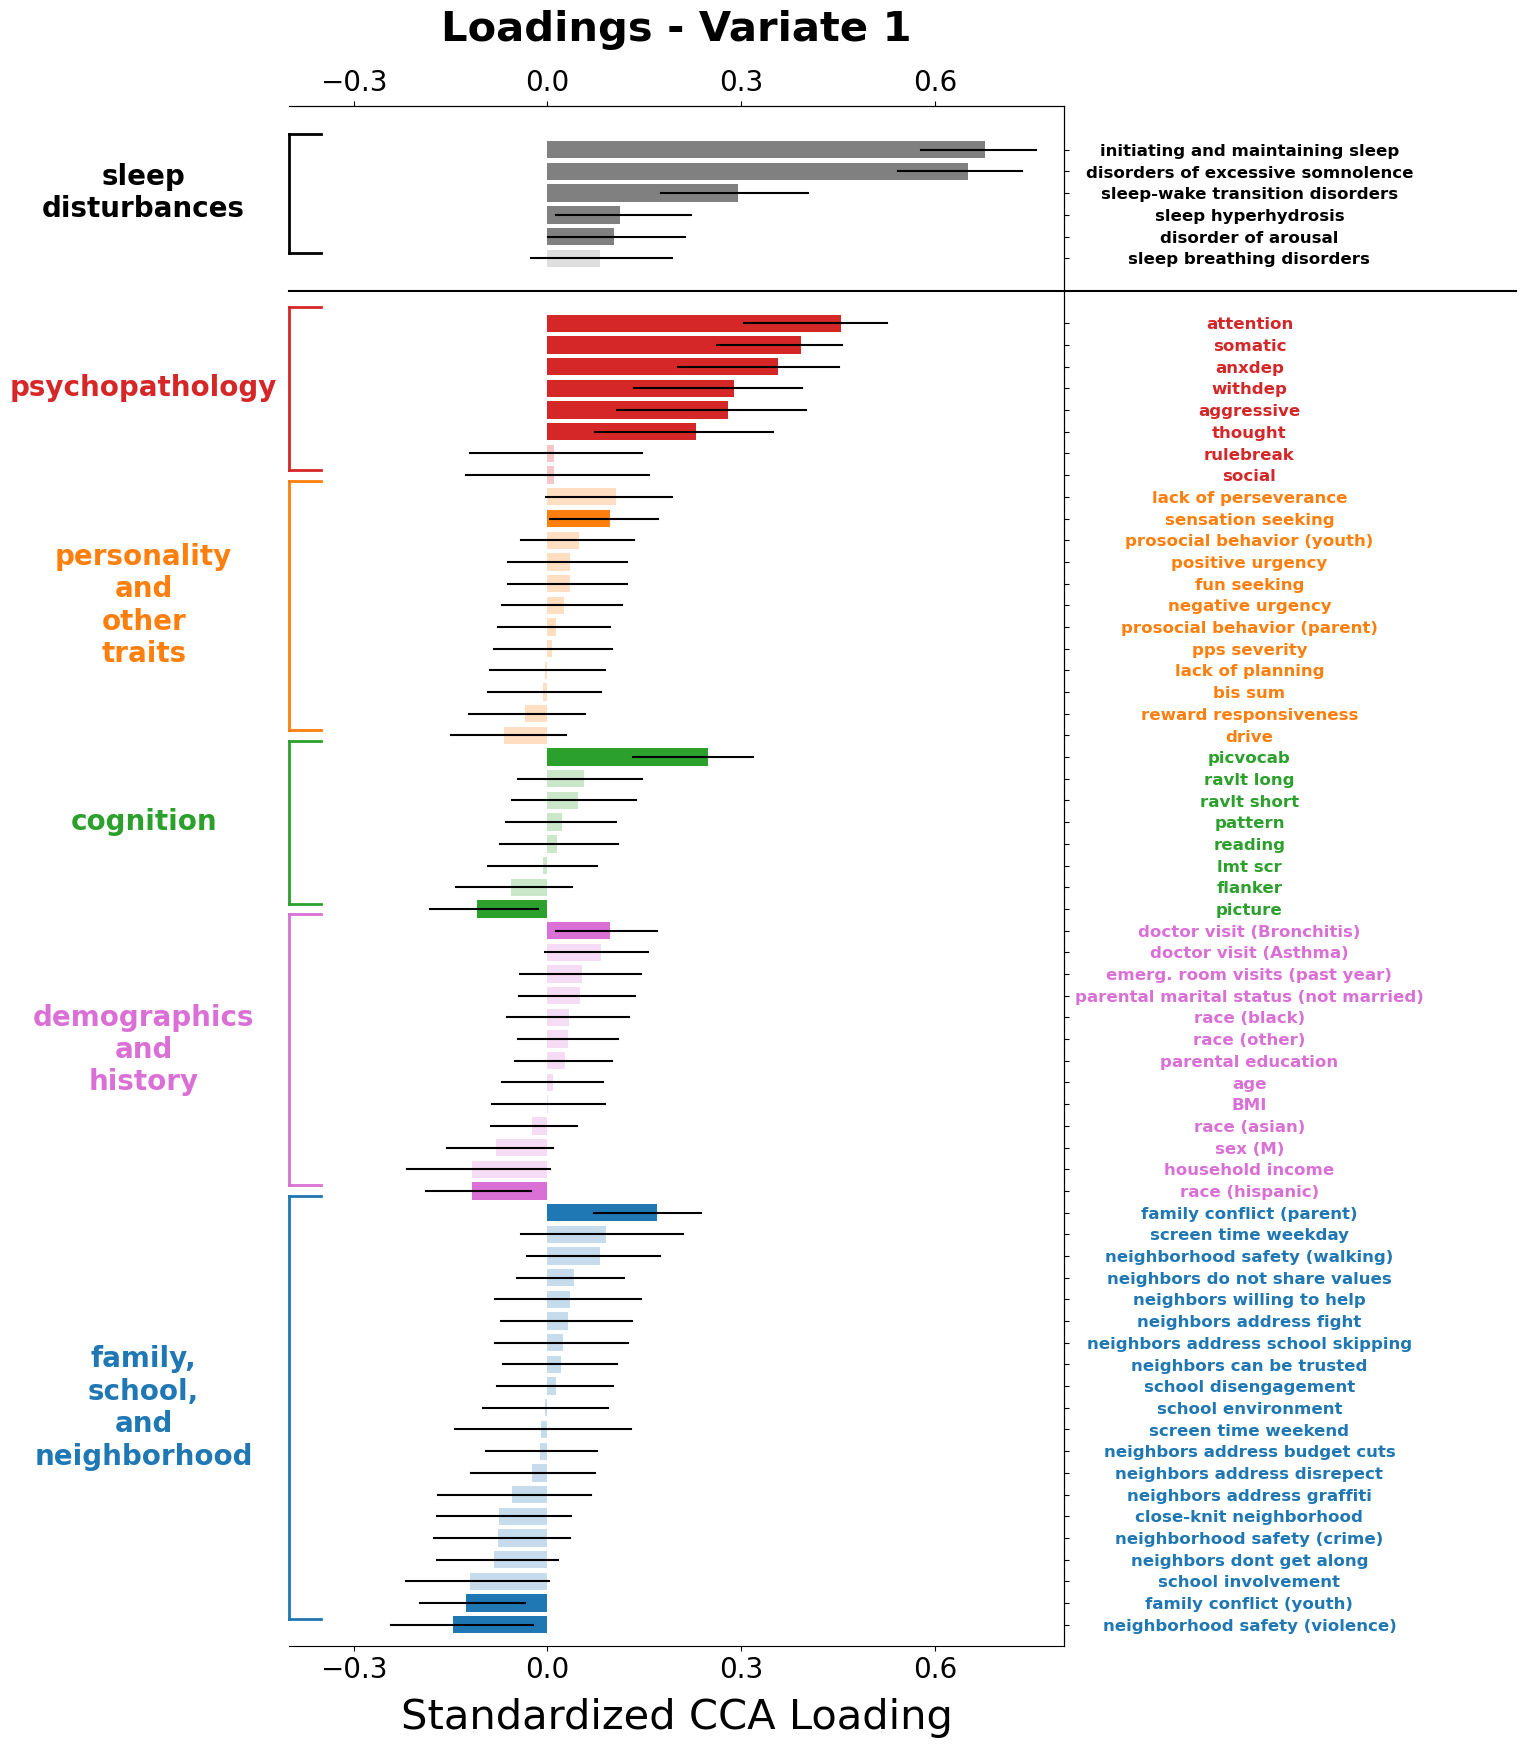

In [19]:
x_ordering = dict()
pheno = []
beta = []
se = []
lower_95_ci = []
upper_95_ci = []

for cv_i in [0]:
    # set up figure
    fig = plt.figure(figsize=(10, 20))
    ax1 = plt.gca()
    
    # get sign flip figure
    sign_flip = np.sign(np.sum(model.x_rotations_[:, cv_i]))
    
    '''
    Plot X Loadings
    '''
    
    # plot all variable loadings based on significance
    running_idx = 0
    tick_labels = []
    tick_colors = []
    
    ind_X = np.arange(X.shape[1])  # + max(ind_Y) + 1
    #for key, val in pred_var_groupings.items():
    for domain in list(domains.keys())[::-1]:
        domain_idx_start = running_idx
        domain_var_idxs = []
        domain_tmp_labs = []
        for key in domains[domain]:
            val = pred_var_groupings[key]
            if key != 'demo':
                val = [v for v in val if v in master_df.columns]
                if len(val) == 0: 
                    print(f'skipping {key}...')
                    continue
            var_idxs = [i for i,x in enumerate(pred_vars) if x in val]
            tmp_labs = [x for x in pred_vars if x in val]
            
            domain_var_idxs.extend(var_idxs)
            domain_tmp_labs.extend(tmp_labs)
            
        var_idxs = domain_var_idxs
        tmp_labs = domain_tmp_labs
        
        sort_order = np.argsort(model.x_rotations_[var_idxs, cv_i])
        x_ordering[domain] = (sort_order, var_idxs, [canonical_names[tmp_labs[i]] for i in sort_order])
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]

        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_x_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.x_rotations_[var_idx, cv_i] * sign_flip, 
                     color=pred_var_color_mapping[domain], alpha=1 if is_sig else 0.25)
            tick_colors.append(pred_var_color_mapping[domain])  #[key])
            
            beta.append(model.x_rotations_[var_idx, cv_i] * sign_flip)
            se.append(np.std(boot_vals))
            lower_95_ci.append(lower_val)
            upper_95_ci.append(upper_val)
        
        pheno.extend(tmp_labs)
        tick_labels += tmp_labs
        running_idx += len(var_idxs)

        bracket_x = -0.4  #0.775
        x1, x2 = bracket_x, bracket_x+0.05   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y1, y2, h, col = domain_idx_start+0.25, running_idx-0.25, 0.5, pred_var_color_mapping[domain]
        plt.plot([x1, x1], [y1, y2], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y1, y1], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y2, y2], lw=2, c=col, clip_on=False)
        plt.text((x1+x2)/2 - 0.25, (y1+y2)/2, 
                 domain.replace(' ', '\n'),
                 ha='center', va='center', color=col, fontweight='bold')
                    
            
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    
    ind_Y = np.arange(Y.shape[1]) + max(ind_X) + 1 + 2
    for key, val in cbcl_var_groupings.items():
        domain_idx_start = running_idx
        
        var_idxs = [i for i,x in enumerate(sleep_cols) if x in val]
        tmp_labs = [x for x in sleep_cols if x in val]
        
        sort_order = np.argsort(model.y_rotations_[var_idxs, cv_i])
        x_ordering[key] = (sort_order, var_idxs, [canonical_names[tmp_labs[i]] for i in sort_order])
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]
        
        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_y_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.y_rotations_[var_idx, cv_i] * sign_flip, 
                     color='gray', alpha=1 if is_sig else 0.25)
            tick_colors.append('k')
            
            beta.append(model.y_rotations_[var_idx, cv_i] * sign_flip)
            se.append(np.std(boot_vals))
            lower_95_ci.append(lower_val)
            upper_95_ci.append(upper_val)
        
        pheno.extend(tmp_labs)
        tick_labels += tmp_labs
        running_idx += len(var_idxs)
        
        
        bracket_x = -0.4  #0.775
        x1, x2 = bracket_x, bracket_x+0.05
        y1, y2, h, col = domain_idx_start+0.25, running_idx-0.25, 0.5, pred_var_color_mapping[key]
        plt.plot([x1, x1], [y1, y2], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y1, y1], lw=2, c=col, clip_on=False)
        plt.plot([x1, x2], [y2, y2], lw=2, c=col, clip_on=False)
        plt.text((x1+x2)/2 - 0.25, (y1+y2)/2, 
                 'sleep\ndisturbances',
                 ha='center', va='center', color=col, fontweight='bold')
        


    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.yaxis.tick_right()

    ax1.set_yticks(list(ind_X) + list(ind_Y)) 
    ax1.get_yaxis().set_tick_params(pad=130)
    ax1.set_yticklabels(tick_labels, fontsize=12, ha='center', fontweight='bold')
    for color, tick in zip(tick_colors, ax1.get_yticklabels()):
        tick.set_color(color)

    
    ax2 = ax1.twiny()
    ax2.spines['left'].set_visible(False)
    
    ax1.set_xlim((-0.4, 0.8))
    ax2.set_xlim((-0.4, 0.8))
    ax1.set_xticks(np.arange(-0.3, 0.7, 0.3))
    ax2.set_xticks(np.arange(-0.3, 0.7, 0.3))
    ax1.set_ylim((-1, running_idx+1))
    
    plt.title(f'Loadings - Variate {cv_i + 1}', fontsize=30, fontweight='bold', pad=20)
    ax1.set_xlabel(f'Standardized CCA Loading', fontsize=30, labelpad=10)
    
    
    break_x = max(list(ind_X) + list(ind_Y)) - Y.shape[1] - 0.5
    line = Line2D([-0.4, 1.5], [break_x, break_x], lw=1.5, color='k', alpha=1)
    line.set_clip_on(False)
    ax1.add_line(line)
    

    plt.show()

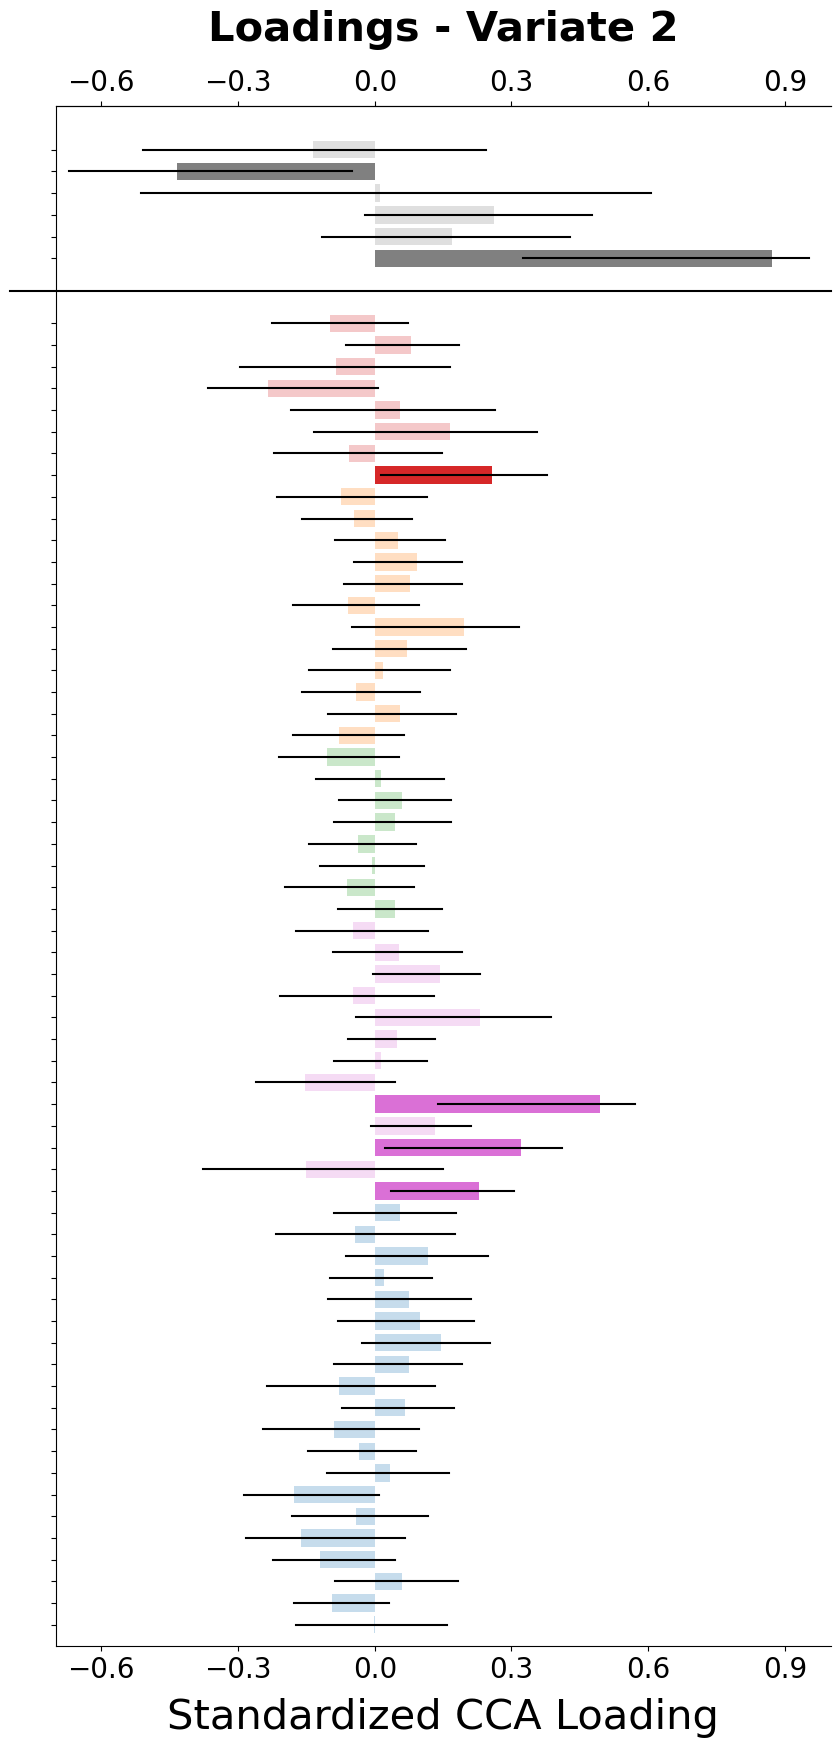

In [21]:
pheno2 = []
beta2 = []
se2 = []
lower_95_ci2 = []
upper_95_ci2 = []

for cv_i in [1]:
    # set up figure
    fig = plt.figure(figsize=(10, 20))
    ax1 = plt.gca()
    
    # get sign flip figure
    sign_flip = np.sign(np.sum(model.x_rotations_[:, cv_i]))
    
    '''
    Plot X Loadings
    '''
    
    # plot all variable loadings based on significance
    running_idx = 0
    tick_labels = []
        
    
    ind_X = np.arange(X.shape[1])  
    for domain in list(domains.keys())[::-1]:
        domain_idx_start = running_idx
        domain_var_idxs = []
        domain_tmp_labs = []
        for key in domains[domain]:
            val = pred_var_groupings[key]
            if key != 'demo':
                val = [v for v in val if v in master_df.columns]
                if len(val) == 0: 
                    print(f'skipping {key}...')
                    continue
            var_idxs = [i for i,x in enumerate(pred_vars) if x in val]
            tmp_labs = [x for x in pred_vars if x in val]
            
            domain_var_idxs.extend(var_idxs)
            domain_tmp_labs.extend(tmp_labs)
            
        var_idxs = domain_var_idxs
        tmp_labs = domain_tmp_labs
        sort_order, saved_var_idxs, sorted_tmp_labs = x_ordering[domain] 
        assert np.all(np.array(var_idxs) == np.array(saved_var_idxs))
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]
        assert np.all(np.array(sorted_tmp_labs) == np.array(tmp_labs))

        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_x_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.x_rotations_[var_idx, cv_i] * sign_flip, 
                     color=pred_var_color_mapping[domain], alpha=1 if is_sig else 0.25)
            
            beta2.append(model.x_rotations_[var_idx, cv_i] * sign_flip)
            se2.append(np.std(boot_vals))
            lower_95_ci2.append(lower_val)
            upper_95_ci2.append(upper_val)
        
        pheno2.extend(tmp_labs)

            
        tick_labels += tmp_labs
        running_idx += len(var_idxs)
            
            
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    ax1.barh([running_idx], [0], color='white', alpha=0)
    running_idx += 1
    
    
    ind_Y = np.arange(Y.shape[1]) + max(ind_X) + 1 + 2
    for key, val in cbcl_var_groupings.items():
        domain_idx_start = running_idx
        
        var_idxs = [i for i,x in enumerate(sleep_cols) if x in val]
        tmp_labs = [x for x in sleep_cols if x in val]
        sort_order, saved_var_idxs, sorted_tmp_labs = x_ordering[key]
        assert np.all(np.array(var_idxs) == np.array(saved_var_idxs))
        var_idxs = np.array(var_idxs)[sort_order]
        tmp_labs = [canonical_names[tmp_labs[i]] for i in sort_order]
        assert np.all(np.array(sorted_tmp_labs) == np.array(tmp_labs))
        
        for var_idx, running_x in zip(var_idxs, np.arange(running_idx, running_idx + len(var_idxs))):
            boot_vals = bootstap_y_loadings[:, var_idx, cv_i]
            lower_val, upper_val = np.percentile(boot_vals, 2.5), np.percentile(boot_vals, 97.5)
            is_sig = False
            if lower_val < 0  and upper_val < 0:
                is_sig = True
            if lower_val > 0  and upper_val > 0:
                is_sig = True
            ax1.plot([lower_val, upper_val], [running_x, running_x], c='k', linewidth=1.5)
            ax1.barh(running_x, model.y_rotations_[var_idx, cv_i] * sign_flip, 
                     color='gray', alpha=1 if is_sig else 0.25)
            
            beta2.append(model.y_rotations_[var_idx, cv_i] * sign_flip)
            se2.append(np.std(boot_vals))
            lower_95_ci2.append(lower_val)
            upper_95_ci2.append(upper_val)
        
        pheno2.extend(tmp_labs)

        
        tick_labels += tmp_labs
        running_idx += len(var_idxs)
        


    ax1.spines['bottom'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_yticks(list(ind_X) + list(ind_Y))  
    ax1.set_yticklabels([])
    
    ax2 = ax1.twiny()
    ax2.spines['right'].set_visible(False)
    ax1.set_xlim((-0.7, 1))
    ax2.set_xlim((-0.7, 1))
    ax1.set_xticks(np.arange(-0.6, 1, 0.3))
    ax2.set_xticks(np.arange(-0.6, 1, 0.3))
    ax1.set_ylim((-1, running_idx+1))
    ax2.spines['left'].set_visible(False)
    
    plt.title(f'Loadings - Variate {cv_i + 1}', fontsize=30, fontweight='bold', pad=20)
    ax1.set_xlabel(f'Standardized CCA Loading', fontsize=30, labelpad=10)
    
    break_x = max(list(ind_X) + list(ind_Y)) - Y.shape[1] - 0.5
    line = Line2D([-0.8, 1], [break_x, break_x], lw=1.5, color='k', alpha=1)
    line.set_clip_on(False)
    ax1.add_line(line)
    

    plt.show()

# Leave One Site Out CCA Performance

In [ ]:
assert X.shape[0] == master_df.shape[0]
unique_sites = master_df.site_id_l.unique()

site_idxs = []
for site_i, test_site in enumerate(tqdm(unique_sites, ncols=1000)):
    test_idxs = np.argwhere(master_df.site_id_l.values.flatten() == test_site).flatten()
    train_idxs = np.array([x for x in np.arange(master_df.shape[0]) if x not in test_idxs])
    site_idxs.append((train_idxs, test_idxs))
    
    
oos_rs = np.zeros((len(unique_sites), 2))

for site_i, (train_idxs, test_idxs) in enumerate(tqdm(site_idxs, ncols=1000)):    
    model = CCA(n_components=2).fit(X[train_idxs, :], Y[train_idxs, :])
    X_transform, Y_transform = model.transform(X[test_idxs, :], Y[test_idxs, :])
    oos_rs[site_i, 0] = scipy.stats.pearsonr(X_transform[:, 0], Y_transform[:, 0])[0]
    oos_rs[site_i, 1] = scipy.stats.pearsonr(X_transform[:, 1], Y_transform[:, 1])[0]
    
print(oos_rs.mean(0))

# CCA Loadings Permutations

In [ ]:
perm_subs, perm_idxs = pickle.load(open(PATH_TO_BLOCK_PERM_IDXS + 'subs_perms_baseline_10k.pickle', 'rb'))
assert np.all(np.array(perm_subs) == master_df.subjectkey.values.flatten())
perm_idxs = perm_idxs - 1
assert perm_idxs.min() == 0
perm_idxs.shape

n_perms = 10000
perm_oos_rs = np.zeros((n_perms, 2))

for perm_i in tqdm(range(n_perms)):
    oos_rs = np.zeros((len(unique_sites), 2))
    Y_perm = Y[perm_idxs[:, perm_i], :]
    for site_i, (train_idxs, test_idxs) in enumerate(site_idxs):    
        model = CCA(n_components=2).fit(X[train_idxs, :], Y_perm[train_idxs, :])
        X_transform, Y_transform = model.transform(X[test_idxs, :], Y_perm[test_idxs, :])
        oos_rs[site_i, 0] = scipy.stats.pearsonr(X_transform[:, 0], Y_transform[:, 0])[0]
        oos_rs[site_i, 1] = scipy.stats.pearsonr(X_transform[:, 1], Y_transform[:, 1])[0]
    perm_res = oos_rs.mean(0)
    perm_oos_rs[perm_i, :] = perm_res
    
pickle.dump(perm_oos_rs, open('./perms_baseline.pickle', 'wb'))